In [2]:
import os
os.environ['XRT_TPU_CONFIG'] = "tpu_worker;0;10.58.103.202:8470"

In [3]:
import cv2

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

## Logging

In [5]:
import logging
from logging.handlers import RotatingFileHandler

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s, %(name)s, %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [6]:
log = logging.getLogger(__name__)

In [7]:
log.info("Hello")

21:16:28, __main__, INFO Hello


## Mean and STD

In [8]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Define augmentations

In [9]:
import numpy as np

from albumentations import (
    HorizontalFlip, GaussianBlur, HueSaturationValue, DualTransform, GaussNoise, OneOf,
    Compose, RandomBrightnessContrast, ImageCompression, ShiftScaleRotate,
    PadIfNeeded, ToGray, FancyPCA, MotionBlur, RandomCrop
)
from torchvision import transforms

In [10]:
gaussian_noise_transform = Compose([
        GaussNoise(p=0.1)],
        additional_targets={'image2': 'image'}
    )

In [11]:
def put_to_center(img, input_size):
    img = img[:input_size, :input_size]
    image = np.zeros((input_size, input_size, 3), dtype=np.uint8)
    start_w = (input_size - img.shape[1]) // 2
    start_h = (input_size - img.shape[0]) // 2
    image[start_h:start_h + img.shape[0], start_w: start_w + img.shape[1], :] = img
    return image

In [12]:
def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC,
                 always_apply=False, p=1):
        super(IsotropicResize, self).__init__(always_apply, p)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):
        return isotropically_resize_image(img, size=self.max_side, interpolation_down=interpolation_down,
                                          interpolation_up=interpolation_up)

In [13]:
def augmentation_pipeline(size=224):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussianBlur(blur_limit=3, p=0.05),
        MotionBlur(p=0.05),
        HorizontalFlip(),
        OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5)],
        additional_targets={'image2': 'image'}
    )

def validation_augmentation_pipeline(size=224):
    return Compose([
        IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
    ])

In [14]:
transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ])

## Define Dataset

In [15]:
from PIL import Image

import albumentations.augmentations.functional as augmentations_functional
from albumentations.pytorch.functional import img_to_tensor
from torch.utils.data import Dataset

In [16]:
class ValidationDataset(Dataset):
    """ Deepfake Validation Dataset """

    def __init__(self, validation_dataframe, augmentations,
                 image_size=224):

        self.image_size = image_size

        if 'index' in validation_dataframe:
            del validation_dataframe['index']

        self.validation_dataframe = validation_dataframe
        self.augmentate = augmentations

    def __getitem__(self, index):
        row = self.validation_dataframe.iloc[index]
        image_name = row["image_path"]
        label = row["label"]

        img = Image.open(image_name).convert("RGB")
        img = np.array(img)

        transformed_image = self.augmentate(image=img)["image"]
        transformed_image = put_to_center(transformed_image, 224)
        transformed_image = img_to_tensor(transformed_image, {"mean": MEAN,
                                                              "std": STD})

        return transformed_image, label

    def __len__(self):
        return len(self.validation_dataframe)

In [17]:
from google.cloud import storage
import io
client = storage.Client()

class DeepfakeDataset(Dataset):
    """Deepfake dataset"""

    def __init__(self, real_frames_dataframe, fake_frames_dataframe,
                 augmentations, non_existing_files, image_size=224):
        self.non_existing_files = set(non_existing_files)
        self.image_size = image_size
        
        
        if 'index' in real_frames_dataframe:
            del real_frames_dataframe['index']

        if 'index' in fake_frames_dataframe:
            del fake_frames_dataframe['index']

        self.augmentate = augmentations

        self.real_df = real_frames_dataframe
        self.fake_df = fake_frames_dataframe

    def __getitem__(self, index):
        row_real = self.real_df.iloc[index]
        row_fake = self.fake_df.iloc[index]

        real_image_name = row_real["image_path"]
        fake_image_name = row_fake["image_path"]
        
#         bucket_fake = str()
#         fake_image_name_bucket = fake_image_name.split('\\')[0]
        
        bucket_fake = client.get_bucket("training_fake_faces")
        bucket_real = client.get_bucket('training_real_faces')
        
        if real_image_name in self.non_existing_files or fake_image_name in self.non_existing_files:
            return None

        try:
            blob = bucket_real.get_blob(real_image_name).download_as_string()
            blob_in_bytes = io.BytesIO(blob)
            img_real = Image.open(blob_in_bytes).convert("RGB")
        except (FileNotFoundError, AttributeError) as e:
            log.info("Real Image not found: {}".format(real_image_name))
            return None
        try:
            blob = bucket_fake.get_blob(fake_image_name).download_as_string()
            blob_in_bytes = io.BytesIO(blob)
            img_fake = Image.open(blob_in_bytes).convert("RGB")
        except (FileNotFoundError, AttributeError) as e:
            log.info("Fake Image not found: {}".format(fake_image_name))
            return None

        img_real = np.array(img_real)
        img_fake = np.array(img_fake)
        transformed_images = self.augmentate(image=img_real, image2=img_fake)
        img_real = transformed_images["image"]
        img_fake = transformed_images["image2"]
        img_fake = augmentations_functional.resize(img_fake, height=224, width=224)
        gaussian_transformed_images = gaussian_noise_transform(image=img_real,
                                                               image2=img_fake)
        img_real = gaussian_transformed_images["image"]
        img_fake = gaussian_transformed_images["image2"]
        # print(img_real.shape)
        # print(img_fake.shape)
        # cv2.imwrite("test_real.png", img_real)
        # cv2.imwrite("test_fake.png", img_fake)
        img_real = img_to_tensor(img_real, {"mean": MEAN,
                                            "std": STD})
        img_fake = img_to_tensor(img_fake, {"mean": MEAN,
                                            "std": STD})

        pair = {
            "real": img_real,
            "fake": img_fake
        }

        return pair

    def __len__(self):
        return len(self.real_df)

# Training

In [18]:
import os
from functools import partial
import pandas as pd
import time

In [19]:
from timm.models.efficientnet import tf_efficientnet_b4_ns

import torch
from torch import distributions
from torch.utils.data import DataLoader
from torch.nn import functional as F, AdaptiveAvgPool2d, Dropout, Linear
import torch.nn as nn
import torch.optim as optim
# import torchvision.models as models uncomment for resnet

### EfficientNet

In [20]:
import timm

encoder_params = {
    "tf_efficientnet_b4_ns": {
        "features": 1792,
        "init_op": partial(tf_efficientnet_b4_ns,
                           num_classes=1,
                           pretrained=True,
                           drop_path_rate=0.2)
    }
}

class DeepfakeClassifier(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.encoder = encoder_params["tf_efficientnet_b4_ns"]["init_op"]()
        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.dropout = Dropout(dropout_rate)
        self.fc = Linear(encoder_params["tf_efficientnet_b4_ns"]["features"], 1)

    def forward(self, x):
        x = self.encoder.forward_features(x)
        x = self.avg_pool(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Resnet

In [3]:
class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)

        self.load_state_dict(torch.load(RESNET_WEIGHTS))

        # Override the existing FC layer with a new one.
        self.fc = nn.Linear(2048, 1)

NameError: name 'models' is not defined

In [18]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [21]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [22]:
PAIR_REAL_DATAFRAME = r"dataframes/final_real.csv"
PAIR_FAKE_DATAFRAME = r"dataframes/final_fake.csv"


VALIDATION_DATAFRAME_PATH = r"dataframes/faces_validation.csv"

In [23]:
import pickle

def create_data_loaders(batch_size, num_workers):
    train_real_df = pd.read_csv(PAIR_REAL_DATAFRAME)
    train_fake_df = pd.read_csv(PAIR_FAKE_DATAFRAME)
    val_df = pd.read_csv(VALIDATION_DATAFRAME_PATH)
    
    with open('non_existing_files', 'rb') as fp:
        non_existing_files = pickle.load(fp)

    train_dataset = DeepfakeDataset(result_real_df, result_fake_df, augmentation_pipeline(), non_existing_files)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              pin_memory=True, collate_fn=collate_fn)

    validation_dataset = ValidationDataset(val_df, validation_augmentation_pipeline())

    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                                   num_workers=num_workers, pin_memory=True)

    return train_loader, validation_loader

## Training and Evaluation Loops

In [24]:
def evaluate(model, minimum_loss, device, test_loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        para_train_loader = pl.ParallelLoader(test_loader, [device]).per_device_loader(device)
    
        for images, labels in para_train_loader:
            images = images
            labels = labels

            outputs = model(images)
            y_pred = outputs.squeeze()
            labels = labels.type_as(y_pred)
            loss = criterion(y_pred, labels)

            running_loss += loss.item() * images.size(0)

        total_loss = running_loss / dataset_size["val"]
        log.info('Validation Loss: {:4f}'.format(total_loss))

        if total_loss < minimum_loss:
            minimum_loss = total_loss

        return minimum_loss

In [29]:
# def train_model(model, criterion, optimizer, scheduler, epochs):
#     since = time.time()
#     minimum_loss = 10000000
#     iteration = 0

#     for epoch in range(epochs):
#         batch_number = 0
#         if iteration == MAX_ITERATIONS:
#             break

#         log.info('Epoch {}/{}'.format(epoch, epochs - 1))
#         log.info('-' * 10)

#         model.train()  # Set model to training mode

#         running_training_loss = 0
#         total_examples = 0
#         for pairs in train_loader:
#             iteration += 1
#             batch_number += 1
#             fake_images = pairs['fake'].to(gpu)
#             real_images = pairs['real'].to(gpu)
#             target = probability_distribution.sample((len(fake_images),)).float().to(gpu)
#             fake_weight = target.view(-1, 1, 1, 1)

#             input_tensor = (1.0 - fake_weight) * real_images + fake_weight * fake_images

#             current_batch_size = input_tensor.shape[0]
#             total_examples += current_batch_size

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             outputs = model(input_tensor)
#             y_pred = outputs.squeeze()

#             loss = criterion(y_pred, target)

#             loss.backward()
#             scheduler.step()
#             xm.optimizer_step(optimizer)

#             # statistics
#             running_training_loss += loss.item() * current_batch_size
#             if batch_number % 500 == 0:
#                 log.info("New 500 batches are evaluated")
#                 log.info("Batch Number: {}".format(batch_number))
#                 time_elapsed = time.time() - since
#                 log.info('Training complete in {:.0f}m {:.0f}s'.format(
#                     time_elapsed // 60, time_elapsed % 60))
#                 max_lr = max(param_group["lr"] for param_group in optimizer.param_groups)
#                 log.info("iteration: {}, max_lr: {}".format(iteration, max_lr))

#             if batch_number >= BATCHES_PER_EPOCH:
#                 break

#             # scheduler.step()

#         epoch_loss = running_training_loss / total_examples
#         log.info('Training Loss: {:.4f}'.format(epoch_loss))
#         history["train"].append(epoch_loss)

#         # Calculate Validation Loss
#         validation_loss = evaluate(model, minimum_loss)
#         history["val"].append(validation_loss)
#         log.info(history)
# #         scheduler.step()

#         # deep copy the model
#         if validation_loss < minimum_loss:
#             minimum_loss = validation_loss
#             log.info("Minimum loss is: {}".format(minimum_loss))
#             # best_model_wts = copy.deepcopy(model.state_dict())
#             torch.save(model.state_dict(), model_save_path)

#     time_elapsed = time.time() - since

#     log.info('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     log.info('Loss: {:4f}'.format(minimum_loss))

#     # load best model weights
#     model.load_state_dict(torch.load(model_save_path))
#     return model

import pickle
MAX_ITERATIONS = 100000
BATCHES_PER_EPOCH = 5000

model_save_path = r"trained_models/lowest_loss_model.pth"

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.debug.metrics as met

FLAGS = {
    'batch_size': 32,
    'num_workers': 8,
    'world_size': 8,
    'epochs': 2,
    'log_steps': 10,
    'metrics_debug': False
}

# SERIAL_EXEC = xmp.MpSerialExecutor()
WRAPPED_MODEL = xmp.MpModelWrapper(DeepfakeClassifier())

def train_model(rank, FLAGS):
    print("Starting train method on rank: {}".format(rank))
    device = xm.xla_device()
    since = time.time()
    minimum_loss = 10000000
    iteration = 0
    
    print("Started to initialise model, loss function, optimizer and scheduler")
    model = WRAPPED_MODEL.to(device)
    print("model")
    criterion = F.binary_cross_entropy_with_logits
    print("criterion")
    optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
    print("optimizer")
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.9)
    print("Model, loss function, optimizer and scheduler is initialised")
    
    print("Started to initialise dataframes")
    train_real_df = pd.read_csv(PAIR_REAL_DATAFRAME)
    train_fake_df = pd.read_csv(PAIR_FAKE_DATAFRAME)
    val_df = pd.read_csv(VALIDATION_DATAFRAME_PATH)
    print("Dataframes initialised")
    
    probability_distribution = distributions.beta.Beta(0.5, 0.5)
    with open('non_existing_files.pickle', 'rb') as fp:
        non_existing_files = pickle.load(fp)
    
    print("Started to initialise datasets")
    train_dataset = DeepfakeDataset(train_real_df, train_fake_df, augmentation_pipeline(), non_existing_files)
#     train_dataset = SERIAL_EXEC.run(train_dataset)
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=FLAGS['world_size'], rank=rank, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=FLAGS['batch_size'], sampler=train_sampler, num_workers=FLAGS['num_workers'], collate_fn=collate_fn)
    
    validation_dataset = ValidationDataset(val_df, validation_augmentation_pipeline())
    validation_sampler = torch.utils.data.distributed.DistributedSampler(validation_dataset, num_replicas=FLAGS['world_size'], rank=rank, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=FLAGS["batch_size"], sampler=validation_sampler, shuffle=False,
                                   num_workers=FLAGS['num_workers'])
    
    print("Datasets initialised")
    
    dataset_size = {
        "val": len(validation_loader.dataset)
    }
    val_size = dataset_size["val"]

    for epoch in range(FLAGS['epochs']):
        batch_number = 0
        if iteration == MAX_ITERATIONS:
            break
            
#         train_loader = DataLoader(train_dataset, batch_size=FLAGS['batch_size'], num_workers=0, collate_fn=collate_fn)
#         device_loader = pl.MpDeviceLoader(train_loader, device)
        
        para_train_loader = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)

        log.info('Epoch {}/{}'.format(epoch, FLAGS['epochs'] - 1))
        log.info('-' * 10)

        model.train()  # Set model to training mode

        running_training_loss = 0
        total_examples = 0
        for pairs in para_train_loader:
            iteration += 1
            batch_number += 1
            fake_images = pairs['fake']
            real_images = pairs['real']
            target = probability_distribution.sample((len(fake_images),)).float()
            print(target.device)
            fake_weight = target.view(-1, 1, 1, 1)

            input_tensor = (1.0 - fake_weight) * real_images + fake_weight * fake_images


            current_batch_size = input_tensor.shape[0]
            total_examples += current_batch_size

            outputs = model(input_tensor)
            y_pred = outputs.squeeze()
            print(y_pred.device)

            loss = criterion(y_pred, target)

             # zero the parameter gradients
            optimizer_ft.zero_grad()
            loss.backward()
            lr_scheduler.step()
            xm.optimizer_step(optimizer_ft)

            # statistics
            running_training_loss += loss.item() * current_batch_size
            if batch_number % 500 == 0:
                log.info("New 500 batches are evaluated")
                log.info("Batch Number: {}".format(batch_number))
                time_elapsed = time.time() - since
                log.info('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                max_lr = max(param_group["lr"] for param_group in optimizer.param_groups)
                log.info("iteration: {}, max_lr: {}".format(iteration, max_lr))
            

            if batch_number >= BATCHES_PER_EPOCH:
                break

            # scheduler.step()

        epoch_loss = running_training_loss / total_examples
        log.info('Training Loss: {:.4f}'.format(epoch_loss))
        history["train"].append(epoch_loss)

        # Calculate Validation Loss
        validation_loss = evaluate(model, minimum_loss, device)
        history["val"].append(validation_loss)
        log.info(history)
#         scheduler.step()

        if FLAGS['metrics_debug']:
            xm.master_print(met.metrics_report())

        # deep copy the model
        if validation_loss < minimum_loss:
            minimum_loss = validation_loss
            log.info("Minimum loss is: {}".format(minimum_loss))
            # best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_save_path)

    time_elapsed = time.time() - since

    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Loss: {:4f}'.format(minimum_loss))

    # load best model weights
    model.load_state_dict(torch.load(model_save_path))
    return model

# Main Program Function Callers

In [30]:
# torch.set_default_tensor_type(torch.FloatTensor)
xmp.spawn(train_model,nprocs=FLAGS['world_size'], args=(FLAGS,), start_method='fork')

Starting train method on rank: 0
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 4
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 7
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 3
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 1
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 2
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 6
Started to initialise model, loss function, optimizer and scheduler
Starting train method on rank: 5
Started to initialise model, loss function, optimizer and scheduler
model
criterion
optimizer
Model, loss function, optimizer and scheduler is initialised
Started to initialise dataframes
Dataframes initialised
Started to initialise datasets


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Datasets initialised


21:29:57, __main__, INFO Epoch 0/1
21:29:57, __main__, INFO ----------


cpu
xla:1


Exception in device=TPU:0: torch_xla/csrc/aten_xla_bridge.cpp:69 : Check failed: xtensor 
*** Begin stack trace ***
	tensorflow::CurrentStackTrace()
	torch_xla::bridge::GetXlaTensor(at::Tensor const&)
	torch_xla::AtenXlaType::mul_(at::Tensor&, at::Tensor const&)
	at::native::binary_cross_entropy_with_logits(at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long)
	torch_xla::AtenXlaType::binary_cross_entropy_with_logits(at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long)
	c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoRuntimeFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long)>::call(c10::OperatorKernel*, at::Tensor const&, at::Tensor

Exception: process 0 terminated with exit code 17

In [ ]:
log.info("Program Started")

# gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# train_loader, validation_loader = create_data_loaders(BATCH_SIZE, 6)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, collate_fn=collate_fn)

validation_dataset = ValidationDataset(val_df, validation_augmentation_pipeline())

validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=True)

dataset_size = {
        "val": len(validation_loader.dataset)
    }

val_size = dataset_size["val"]
log.info(f"Dataloaders Created")
log.info(f"Size of validation dataloader is {val_size}")
# model = MyResNeXt()


# train_dataset = SERIAL_EXEC.run(train_dataset)
# train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=8, rank=rank)

# model = WRAPPED_MODEL.to(device)
log.info("Model is initialised")

# model = model.to(gpu)
# freeze_until(model, "layer4.0.conv1.weight")
# criterion = F.binary_cross_entropy_with_logits
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
# lr_scheduler = lr_scheduler.LambdaLR(optimizer_ft, lambda iteration: (MAX_ITERATIONS - iteration) / MAX_ITERATIONS)
# lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.9)
# probability_distribution = distributions.beta.Beta(0.5, 0.5)

log.info("Training Begins")

history = {
    "train": [],
    "val": []
}


model = train_model(model, criterion, optimizer_ft, lr_scheduler, 25)

## Connect to Google Cloud Storage

In [72]:
from google.cloud import storage
client = storage.Client()
bucket = client.get_bucket('training_fake_faces')
blob = bucket.get_blob('training_fake_faces/aabmgfhcgg/aabmgfhcgg_0.png').download_as_string()

In [76]:
# training_real_faces\htrvdkeosw\htrvdkeosw_200.png
# training_real_faces/training_real_faces/htrvdkeosw/htrvdkeosw_200.png
from google.cloud import storage
client = storage.Client()
bucket = client.get_bucket('training_real_faces')
blob = bucket.get_blob('training_real_faces/htrvdkeosw/htrvdkeosw_0.png').download_as_string()

In [77]:
from google.cloud import storage
client = storage.Client()
bucket = client.get_bucket('training_real_faces')
blob = bucket.get_blob('training_real_faces/htrvdkeosw/htrvdkeosw_200.png').download_as_string()

In [79]:
# training_real_faces\gwoqohzfgp\gwoqohzfgp_180.png

from google.cloud import storage
client = storage.Client()
bucket = client.get_bucket('training_real_faces')
blob = bucket.get_blob('training_real_faces/gwoqohzfgp/gwoqohzfgp_180.png').download_as_string()

In [13]:
# blob
import io
blob_in_bytes = io.BytesIO(blob)

In [6]:
from PIL import Image

In [14]:
im = Image.open(blob_in_bytes)

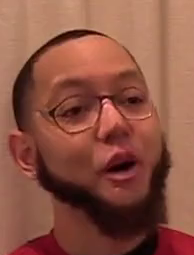

In [15]:
im

In [ ]:
blob = bucket.blob(image_name).download_as_string()
blob_in_bytes = io.BytesIO(blob)

In [4]:
os.environ

environ{'SHELL': '/bin/bash',
        'OS_IMAGE_FAMILY': 'debian-10',
        'CONDA_EXE': '/opt/conda/bin/conda',
        '_CE_M': '',
        'DL_ANACONDA_HOME': '/opt/conda',
        'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework',
        'DL_PATH_DEPS': '/opt/deeplearning/deps',
        'DL_BIN_PATH': '/opt/deeplearning/bin',
        'BINARIES_PATH': '/opt/deeplearning/binaries',
        'PWD': '/home/jupyter',
        'GSETTINGS_SCHEMA_DIR': '/opt/conda/share/glib-2.0/schemas',
        'LOGNAME': 'jupyter',
        'CONDA_PREFIX': '/opt/conda',
        'GSETTINGS_SCHEMA_DIR_CONDA_BACKUP': '',
        'JUPYTER_DEPS_PATH': '/opt/deeplearning/jupyter',
        'ENV_URI_FILE_PATH': '/opt/deeplearning/metadata/env_uri',
        'HOME': '/home/jupyter',
        'RESTRICTION_TYPE_FILE_PATH': '/opt/deeplearning/restriction',
        'LANG': 'C.UTF-8',
        'ENV_VERSION_FILE_PATH': '/opt/deeplearning/metadata/env_version',
        'CONDA_PROMPT_MODIFIER': '(base) ',
     

In [40]:
probability_distribution = distributions.beta.Beta(0.5, 0.5)
example = probability_distribution.sample((len([1,2,3,4,5,6,7,8,9,0]),)).float().to(xla_device)

In [35]:
xla_device = xm.xla_device()
example.to(xla_device)

tensor([0.7947, 0.9402, 0.0374, 0.6944, 0.6579, 0.9608, 0.8656, 0.9532, 0.3380,
        0.9606], device='xla:1')